In [1]:
#import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#Number of flower  classes
NUM_CLASSES = 5 

#Epoches
STAGE1_EPOCHS = 10
STAGE2_EPOCHS = 10

2025-10-29 11:28:53.852237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761737334.030231      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761737334.093454      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install tensorflow

**incase tensorflow version not their**
import tensorflow as tf
print(tf.__version__)

 Model | Input Resolution | Depth | Width | Parameters (approx.) | Relative Accuracy |
| ------ | ---------------- | -------- | -------- | -------------------- | ----------------- |
| **B0** | 224×224 | baseline | baseline | 5.3M | baseline |
| **B1** | 240×240 | ↑ | ↑ | 7.8M | higher |
| **B2** | 260×260 | ↑ | ↑ | 9.2M | higher |
| **B3** | 300×300 | ↑ | ↑ | 12M | higher |
| **B4** | 380×380 | ↑ | ↑ | 19M | higher |
| **B5** | 456×456 | ↑ | ↑ | 30M | higher |
| **B6** | 528×528 | ↑ | ↑ | 43M | higher |
| **B7** | 600×600 | ↑ | ↑ | 66M | highest |

In [3]:
#path as parameters
train_dir = "/kaggle/input/flowers-recognition/flowers"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
#Data Generators with Validation Split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  #20% validation
)

In [5]:
# =====================================================
# 3️⃣ Data Generators with Validation Split
# =====================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 20% for validation
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1761737358.688560      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
#Compile stage1(feature extraction)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("best_model_stage.h5", monitor="val_accuracy", save_best_only = True,  verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

In [8]:
#Train Stage1
history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE1_EPOCHS,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1761737378.225916      78 service.cc:148] XLA service 0x78b2cc002830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761737378.226657      78 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761737380.018454      78 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/109 ━━━━━━━━━━━━━━━━━━━━ 46:34 26s/step - accuracy: 0.3750 - loss: 1.6025

I0000 00:00:1761737388.644599      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5652 - loss: 1.1166
Epoch 1: val_accuracy improved from -inf to 0.86047, saving model to best_model_stage.h5
109/109 ━━━━━━━━━━━━━━━━━━━━ 122s 894ms/step - accuracy: 0.5664 - loss: 1.1141 - val_accuracy: 0.8605 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8474 - loss: 0.4978
Epoch 2: val_accuracy improved from 0.86047 to 0.89419, saving model to best_model_stage.h5
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 446ms/step - accuracy: 0.8474 - loss: 0.4977 - val_accuracy: 0.8942 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8716 - loss: 0.4072
Epoch 3: val_accuracy improved from 0.89419 to 0.90233, saving model to best_model_stage.h5
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 450ms/step - accuracy: 0.8715 - loss: 0.4071 - val_accuracy: 0.9023 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0

In [9]:
#Train Stage1
history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE1_EPOCHS,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8662 - loss: 0.3804
Epoch 1: val_accuracy did not improve from 0.90233
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 466ms/step - accuracy: 0.8663 - loss: 0.3803 - val_accuracy: 0.8977 - val_loss: 0.3253 - learning_rate: 0.0010
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8899 - loss: 0.3373
Epoch 2: val_accuracy did not improve from 0.90233
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.8899 - loss: 0.3373 - val_accuracy: 0.8919 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8911 - loss: 0.3196
Epoch 3: val_accuracy did not improve from 0.90233
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 439ms/step - accuracy: 0.8911 - loss: 0.3196 - val_accuracy: 0.8907 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8992 - loss: 0.3069
Epoch 4: val_accuracy did not improve from 0.90233
109/109 ━━━━

In [10]:
# =====================================================
# 7️⃣ Fine-Tuning Stage 1 (Unfreeze Top Layers)
# =====================================================
model.load_weights("best_model_stage.h5")

# Unfreeze top 40 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_ft = ModelCheckpoint("best_model_finetuned.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop_ft = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr_ft = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

In [11]:
# Train Stage 2 (Fine-Tuning)
history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE2_EPOCHS,
    callbacks=[checkpoint_ft, earlystop_ft, reduce_lr_ft]
)


Epoch 1/10


E0000 00:00:1761738344.047160      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761738344.253264      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761738344.524843      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761738344.730866      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 14/109 ━━━━━━━━━━━━━━━━━━━━ 33s 350ms/step - accuracy: 0.8221 - loss: 0.5173

E0000 00:00:1761738360.577464      78 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761738360.764752      78 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8282 - loss: 0.4923
Epoch 1: val_accuracy improved from -inf to 0.89651, saving model to best_model_finetuned.h5
109/109 ━━━━━━━━━━━━━━━━━━━━ 103s 638ms/step - accuracy: 0.8283 - loss: 0.4920 - val_accuracy: 0.8965 - val_loss: 0.3226 - learning_rate: 1.0000e-05
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8611 - loss: 0.4109
Epoch 2: val_accuracy did not improve from 0.89651
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.8611 - loss: 0.4109 - val_accuracy: 0.8872 - val_loss: 0.3332 - learning_rate: 1.0000e-05
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8752 - loss: 0.3623
Epoch 3: val_accuracy did not improve from 0.89651
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.8752 - loss: 0.3623 - val_accuracy: 0.8802 - val_loss: 0.3376 - learning_rate: 1.0000e-05
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8801 - loss: 0.3390
Epoch 4: val_accura

In [12]:
# Save the final fine-tuned model
model.save("efficientnet_flower_final.h5")


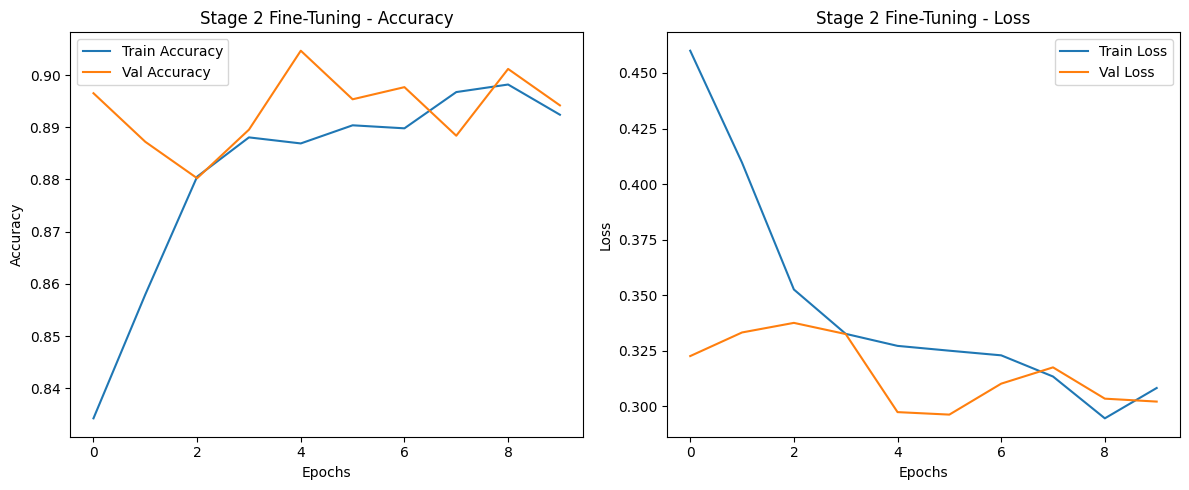

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot Stage 2 metrics
plot_metrics(history_stage2, "Stage 2 Fine-Tuning")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Flower: daisy


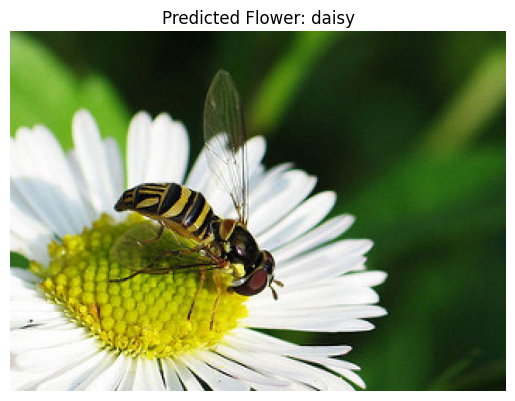

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/kaggle/input/flowers-recognition/flowers/daisy/5547758_eea9edfd54_n.jpg'  
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_labels = list(train_gen.class_indices.keys())
print("Predicted Flower:", class_labels[predicted_class])


# Display image with predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted Flower: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


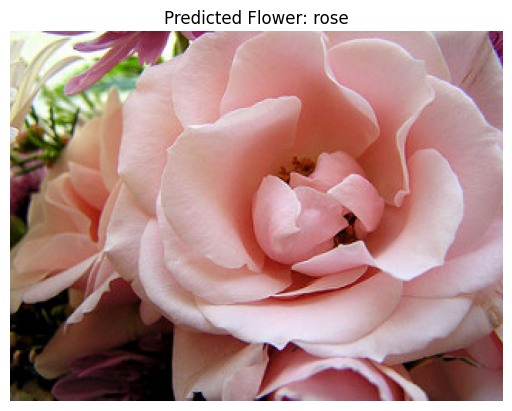

In [15]:
img_path = '/kaggle/input/flowers-recognition/flowers/rose/12240303_80d87f77a3_n.jpg'

# Load and preprocess
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_labels = list(train_gen.class_indices.keys())

# Display image and prediction
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted Flower: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
